In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


from imblearn.over_sampling import RandomOverSampler
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    log_loss,
    confusion_matrix,
    classification_report,
    average_precision_score,
    auc
)
import time
import joblib
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

np.random.seed(0)

/Users/Shared/Py-приколы/Sandbox/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Dataset_2_DATA.csv", encoding='cp1251')[lambda df: df['DAGSOORT'] == 1]
df_d = pd.read_csv("Dataset_2_DESCRIPTION.csv", encoding='cp1251')

## Подготовка данных

### 1. Обработка пропущенных значений 

In [3]:
# Проверяем датафрейм на содержание NaN-значений
has_any_missing = df.isna().any().any()
print("Есть ли NaN в датафрейме?", has_any_missing)

# Может показаться, что пропусков нет, но если проверить столбцы на соотвествие типу object можно понять,
# что два столбца потенциально могут содержать "нетипичные" пропуски.
print(df.dtypes[df.dtypes != 'int64'])

# Проверим уникальные значения столбцов KREISDUUR и PARKEERKOSTEN
for col in df.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения в {col}:")
    print(df[col].unique())

# Бинго! Пропуски в наборе данных обозначаются одним пробелом(' ')

Есть ли NaN в датафрейме? False
KREISDUUR        object
PARKEERKOSTEN    object
dtype: object
Уникальные значения в KREISDUUR:
['11' '8' '7' '5' '4' '3' '10' '6' '2' '9' ' ' '1']
Уникальные значения в PARKEERKOSTEN:
['0' '9' '3' '11' ' ' '13' '5' '4' '14' '12' '16' '10' '7' '2' '6' '1' '8']


In [4]:
# Заменяем пропуски на NaN-значение
df = df.replace({' ': np.nan})

# Функция для замены пропусков модой (или средним) значением
def fill_with_mode(group):
    mode_vals = group.mode()
    if not mode_vals.empty:
        return group.fillna(mode_vals.iloc[0])
    return group.fillna(group.mean())

# Заменяем пропуски в найденных столбцах
cols_to_fill = ['KREISDUUR', 'PARKEERKOSTEN']
for col in cols_to_fill:
    df[col] = df.groupby('PERSID')[col].transform(fill_with_mode)

### 2. Удаление дубликатов

In [5]:
df = df.drop_duplicates()
display(df) # Как можно заметить, количество строк не изменилось
print(df.info())

,HHID,PERSID,VPLID,RitID,HH_VALID,P_VALID,KHVM,WEGGEWEEST,VERTREKP,AANTVPL,...,HHAUTO_N,HHAUTO,HHBESTEL,HHHYBRID,HHMOTOR,HHBROM,HHSNOR,HHFIETS,HHVOUWFIETS,HHEBIKE
0,30055622,3005562201,13957101,1395710101,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
1,30055622,3005562201,13957102,1395710201,2,3,2,1,2,2,...,3,1,0,0,1,0,0,1,0,1
2,30055622,3005562201,13957201,1395720101,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
3,30055622,3005562201,13957202,1395720201,2,3,1,1,2,4,...,3,1,0,0,1,0,0,1,0,1
7,30356310,3035631001,17204101,1720410101,2,3,8,1,2,1,...,2,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7304,30862294,3086229401,19042102,1904210201,2,3,1,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7306,30862294,3086229401,19042103,1904210301,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7307,30862294,3086229401,19042104,1904210401,2,3,7,1,2,5,...,1,1,0,0,0,0,0,1,0,0
7308,30862294,3086229401,19042201,1904220101,2,3,1,1,2,3,...,1,1,0,0,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 0 to 7309
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   HHID                     5700 non-null   int64 
 1   PERSID                   5700 non-null   int64 
 2   VPLID                    5700 non-null   int64 
 3   RitID                    5700 non-null   int64 
 4   HH_VALID                 5700 non-null   int64 
 5   P_VALID                  5700 non-null   int64 
 6   KHVM                     5700 non-null   int64 
 7   WEGGEWEEST               5700 non-null   int64 
 8   VERTREKP                 5700 non-null   int64 
 9   AANTVPL                  5700 non-null   int64 
 10  VPLDAGNR                 5700 non-null   int64 
 11  VERPL                    5700 non-null   int64 
 12  VERPLNR                  5700 non-null   int64 
 13  TOER                     5700 non-null   int64 
 14  TOER_TYPE                5700 non-null   int6

### 3. Приведение типов данных

In [6]:
# Для качественной работы LightAutoML нужно перевести int64-столбцы к category
# Получение признаков и их типов
var_types = df_d[['Variable', 'Measurement_level']].drop_duplicates()

# Сопоставим с колонками датасета
matched_columns = pd.DataFrame(df.columns, columns=['Variable'])
merged = matched_columns.merge(var_types, on='Variable', how='left')

# Делаем списки переменных
nominal_cols = list(merged[merged['Measurement_level'] == 'Nominal']['Variable'])
ordinal_cols = list(merged[merged['Measurement_level'] == 'Ordinal']['Variable'])
scale_cols = list(merged[merged['Measurement_level'] == 'Scale']['Variable'])

# Удаление юзлесс переменных с типовм Scale
id_cols = ['HHID', 'PERSID', 'VPLID', 'RitID']
df = df.drop(columns=id_cols, errors='ignore')

# Приведение типов данных в соответствии с файлом DECRIPTION
for col in nominal_cols + ordinal_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 0 to 7309
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   HH_VALID                 5700 non-null   category
 1   P_VALID                  5700 non-null   category
 2   KHVM                     5700 non-null   category
 3   WEGGEWEEST               5700 non-null   category
 4   VERTREKP                 5700 non-null   category
 5   AANTVPL                  5700 non-null   category
 6   VPLDAGNR                 5700 non-null   category
 7   VERPL                    5700 non-null   category
 8   VERPLNR                  5700 non-null   category
 9   TOER                     5700 non-null   category
 10  TOER_TYPE                5700 non-null   category
 11  AANTRIT                  5700 non-null   category
 12  KMOTIEF                  5700 non-null   category
 13  VERTPROV                 5700 non-null   category
 14  AANKPROV     

#### **Целевая переменная (таргет):**
**`KHVM`** — класс основного вида транспорта для поездки. 

Категории:
1. Car as driver (Водитель автомобиля)
2. Car as passenger (Пассажир автомобиля)
3. Train (Поезд)
4. Bus/tram/metro (Автобус/трамвай/метро)
5. Scooter/moped (Скутер/мопед)
6. Bicycle (Велосипед)
7. Walking (Пешком)
8. Other (Другое).

#### 1. **Демографические и домохозяйственные данные:**
- **`HHSAM`** — состав домохозяйства (например, наличие детей может влиять на выбор транспорта).
- **`HHBRUTOINK2_w5`** — доход домохозяйства (высокий доход может коррелировать с использованием автомобиля).
- **`HHAUTO`, `HHBESTEL`, `HHHYBRID`, `HHMOTOR`, `HHBROM`, `HHSNOR`, `HHFIETS`, `HHVOUWFIETS`, `HHEBIKE`** — Наличие транспортных средств.

#### 2. **Географические и инфраструктурные данные:**
- **`STED_GM`** — уровень урбанизации (влияет на доступность общественного транспорта).
- **`PROV`** — провинция (региональные различия в транспортных привычках).
- **`vlokatie_station`** — расстояние до ближайшей ж/д станции.
- **`vlokatie_bushalte4xpu`** — расстояние до часто ходящего автобуса.

#### 3. **Характеристики поездки:**
- **`KAFSTV`** — класс расстояния поездки (короткие поездки чаще на велосипеде/пешком).
- **`KVERTTIJD`** — время начала поездки (пиковые часы могут влиять на выбор транспорта).
- **`DOEL`** — цель поездки (например, работа, шопинг).
- **`MOTIEF`** — мотив поездки (деловой, leisure и т.д.).
- **`TOER`** — является ли поездка круговой (может влиять на выбор транспорта).

#### 4. **Личные предпочтения и отношение к транспорту:**
- **`OORDEEL_AUTO`** — Оценка автомобиля.  
- **`OORDEEL_TREIN`** — Оценка поезда.  
- **`OORDEEL_BTM`** — Оценка общественного транспорта.  
- **`OORDEEL_FIETS`** — Оценка велосипеда.  
- **`OORDEEL_BROMMER`** — Оценка мопеда. 
- **`OORDEEL_LOPEN`** — Оценка ходьбы.
- **`GEBRUIK_AUTO_STELLING3` / `GEBRUIK_AUTO_STELLING4`** — Восприятие авто (экономия времени, безопасность). 
- **`GEBRUIK_TREIN_STELLING3` / `GEBRUIK_TREIN_STELLING4`** — Восприятие поезда.
- **`GEBRUIK_BTM_STELLING3` / `GEBRUIK_BTM_STELLING4`** — Восприятие общественного транспорта.
- **`GEBRUIK_FIETS_STELLING2` / `GEBRUIK_FIETS_STELLING3`** — Восприятие велосипеда.
- **`GEBRUIK_LOPEN_STELLING3` / `GEBRUIK_LOPEN_STELLING4`** — Восприятие ходьбы.

#### 5. **Данные о транспортных средствах:**
- **`ROLAUTO`** — роль в поездке (водитель/пассажир).
- **`PARKEERKOSTEN`** — стоимость парковки (может влиять на решение использовать автомобиль).

In [7]:
# Отфильтруем нужные столбцы
columns_of_interest = [
    'KHVM', 'AANTVPL', 'KAFSTV', 'KMOTIEF', 'TOER', 'ROLAUTO', 'OORDEEL_AUTO', 'OORDEEL_TREIN', 'OORDEEL_BTM', 'OORDEEL_FIETS', 'OORDEEL_BROMMER', 'OORDEEL_LOPEN',
    'GEBRUIK_AUTO_STELLING3', 'GEBRUIK_AUTO_STELLING4',
    'GEBRUIK_TREIN_STELLING3', 'GEBRUIK_TREIN_STELLING4',
    'GEBRUIK_BTM_STELLING3', 'GEBRUIK_BTM_STELLING4',
    'GEBRUIK_FIETS_STELLING2', 'GEBRUIK_FIETS_STELLING3',
    'GEBRUIK_LOPEN_STELLING3', 'GEBRUIK_LOPEN_STELLING4',
    'HHBRUTOINK2_w5', 'HHAUTO', 'HHPERS', 'HHBESTEL', 
    'HHHYBRID', 'HHMOTOR', 'HHBROM', 'HHSNOR',
    'HHFIETS', 'HHVOUWFIETS', 'HHEBIKE'
]

df_corr = df[columns_of_interest]
corr_matrix = df_corr.corr()


fig = px.imshow(
    corr_matrix, 
    height=1000, 
    width=1000, 
    text_auto='.2f', 
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1
)

fig.update_layout(
    title = {'text': 'Матрица корреляций признаков, связанных с основным видом транспорта (KHVM)', 'x': 0.5},
    margin=dict(t=100, b=50, l=50, r=50),
    font=dict(size=14) 
)

fig.show()


#### Выводы:
1. `ROLAUTO` - высокая отрицательная корреляция −0.74. Звучит логично т.к. если ROLAUTO равен 1(пассажир) или 2(водитель), то значение таргета KHVM ниже - относится к классам 1 или 2, а не 3-8.
2. `KAFSTV` - средняя отрицательная корреляция -0,43. Так же объяснение лежит на поверхности: чем длиннее поездка (больше KAFSTV), тем больше людей выберут авто/поезд как вид транспорта (меньше KHVM).
3. `TOER` - умеренная положительная корреляция. Интерпретация может заключаться в том, что если маршрут круговой(прогулка, поездка на велосипеде, работа) люди предпочитают использовать KHVM с большими порядковыми числами(пешком, СИД и тд).

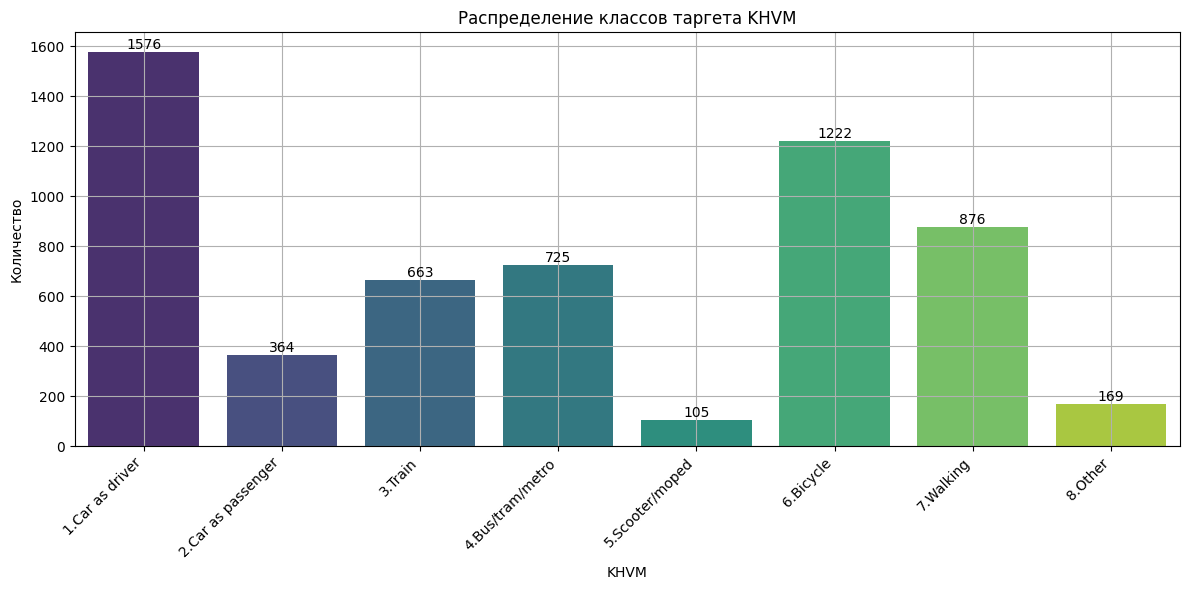

In [8]:
labels = {
    1: '1.Car as driver',
    2: '2.Car as passenger',
    3: '3.Train',
    4: '4.Bus/tram/metro',
    5: '5.Scooter/moped',
    6: '6.Bicycle',
    7: '7.Walking',
    8: '8.Other'
}

# Подсчет количества измерений для каждого класса
class_counts = df['KHVM'].value_counts().sort_index()

# Построение гистограммы распределения классов KHVM
plt.figure(figsize=(12, 6))
sns.countplot(x=df['KHVM'], hue=df['KHVM'], palette='viridis', legend=False)
plt.title('Распределение классов таргета KHVM')
plt.ylabel('Количество')

# Установка пользовательских меток на оси X
plt.xticks(ticks=range(len(labels)), labels=[labels[i] for i in range(1, 9)], rotation=45, ha='right')

# Добавление текста с количеством измерений над каждым столбцом
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.grid(True)
plt.tight_layout()

## 4. Разбиение на train/test выборки

Для задачи мультиклассовой классфикации таргета `KHVM` выберем стандартное деление 70% для train-выборки и 30% для test-выборки - компромисс между качественным обучением модели и надёжной валидацией её предсказательной способности. Это деление позволяет сохранить репрезентативность всех классов, особенно при стратифицированном разбиении, что критически важно для оценки качества модели на всех категориях целевой переменной.

In [9]:
target_name = 'KHVM'
y = df[target_name]
X = df.drop(columns=[target_name])


# Стратифицированное деление, чтобы сохранить баланс классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)


ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X_train, y_train)

# Объединяем обратно
train_data = X_res.copy()
train_data[target_name] = y_res

print(train_data)


     HH_VALID P_VALID WEGGEWEEST VERTREKP AANTVPL VPLDAGNR VERPL VERPLNR TOER  \
0           2       3          1        1       4        2     1       3    0   
1           2       3          1        1       2        3     1       1    0   
2           2       3          1        1       3        3     0       3    0   
3           2       3          1        1       4        3     1       2    0   
4           2       3          1        1       2        2     1       2    0   
...       ...     ...        ...      ...     ...      ...   ...     ...  ...   
8819        2       3          1        1       3        2     1       3    0   
8820        2       3          1        1       5        1     1       2    0   
8821        2       3          1        1       6        1     1       2    0   
8822        2       3          1        1       4        3     1       1    0   
8823        2       3          1        1       4        1     1       3    0   

     TOER_TYPE  ... HHAUTO 

## AutoML (LightAutoML)

Для реализации AutoML-модели я выбрал библиотеку LAMA от братьев наших меньших из сбера.
Далее идет описание AutoML-пайплайна:

In [16]:
categorical_columns = list(train_data.select_dtypes(include=['category']).columns)

task = Task('multiclass', metric='crossentropy')

roles = {
    'target': 'KHVM'
}

automl = TabularAutoML(
    task=task,
    timeout=1500,
    cpu_limit=6,
    memory_limit=10000,
    reader_params={
        'n_jobs': 4,
        'cv': 5
    },
    lgb_params={
        'default_params': {
            'metric': 'multi_logloss',
        }
    },
    tuning_params={
        'max_iters': 20,
    }
)

start = time.time()
oof_preds = automl.fit_predict(train_data, roles=roles, verbose=1)
print("⏱ Обучение заняло:", round(time.time() - start, 2), "секунд")

joblib.dump(automl, "automl_khvm_model.joblib")
print("✅ Модель сохранена в 'automl_khvm_model.joblib'")


[12:41:16] Stdout logging level is INFO.
[12:41:16] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:41:16] Task: multiclass

[12:41:16] Start automl preset with listed constraints:
[12:41:16] - time: 1500.00 seconds
[12:41:16] - CPU: 6 cores
[12:41:16] - memory: 10000 GB

[12:41:16] Train data shape: (8824, 52)

[12:41:20] Layer 1 train process start. Time left 1496.16 secs
[12:41:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:41:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.08666419964199465
[12:41:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:41:40] Time left 1475.56 secs

[12:41:48] Selector_LightGBM fitting and predicting completed
[12:41:48] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:42:28] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.03580168463014494
[12:42:28] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:42:28] Start hyperparameters optimiza

Optimization Progress:  12%|█▏        | 12/101 [02:03<15:19, 10.33s/it, best_trial=10, best_value=-0.0364]

[12:44:32] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[12:44:32] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[12:44:43] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.03082582833249518
[12:44:43] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[12:44:43] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[12:45:55] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.0329107451047566
[12:45:55] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[12:45:55] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:  20%|█▉        | 20/101 [05:04<20:31, 15.20s/it, best_trial=11, best_value=-0.0337]

[12:50:59] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[12:50:59] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[12:52:43] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.030147051264820944
[12:52:43] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[12:52:43] Time left 813.20 secs

[12:52:43] Layer 1 training completed.

[12:52:43] Layer 2 train process start. Time left 813.19 secs
[12:52:43] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[12:52:52] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.039803680325852395
[12:52:52] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:52:52] Time left 803.89 secs

[12:52:52] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[12:53:34] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.03580168463014494
[12:53:34] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:53:34] Time left 762.08 secs

[12:53:34] Layer 2 training completed.

[12:53:34] Blending: optimization starts with equal weights. Score = -0.0351010
[12:53:34] Blending: iteration 0: score = -0.0349680, weights = [0.3554407

Далее тестируем модель и расчитываем метрики

In [10]:
automl = joblib.load("automl_khvm_model.joblib")
# Предсказания
X_test_clean = X_test.copy()
test_preds = automl.predict(X_test_clean)

# Получаем метки классов в правильном порядке
class_labels = np.array(test_preds.features)  # список меток классов

# Обработка предсказаний
y_proba = test_preds.data  # вероятности
y_pred_idx = y_proba.argmax(axis=1)  # индексы наиболее вероятных классов
y_pred = class_labels[y_pred_idx]    # индексы → реальные метки

# Приводим y_true к тому же типу
y_true = y_test.astype(class_labels.dtype)

# Метрики
print("\n📊 Основные метрики:")
print(f"Accuracy:      {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Macro:      {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Weighted:   {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss:      {log_loss(y_true, y_proba, labels=class_labels):.4f}")

print("\n🧩 Матрица ошибок:")
print(confusion_matrix(y_true, y_pred, labels=class_labels))

print("\n📝 Классификационный отчёт:")
print(classification_report(y_true, y_pred, labels=class_labels))



📊 Основные метрики:
Accuracy:      0.9637
F1 Macro:      0.9627
F1 Weighted:   0.9637
Log Loss:      0.1073

🧩 Матрица ошибок:
[[473   0   0   0   0   0   0   0]
 [  0 109   0   0   0   0   0   0]
 [  0   0 199   0   0   0   0   0]
 [  0   0   0 217   0   0   0   0]
 [  0   0   0   0  29   2   0   0]
 [  0   0   0   0   0 342  23   2]
 [  0   0   0   0   0  29 234   0]
 [  0   0   0   0   0   6   0  45]]

📝 Классификационный отчёт:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       473
           2       1.00      1.00      1.00       109
           3       1.00      1.00      1.00       199
           4       1.00      1.00      1.00       217
           5       1.00      0.94      0.97        31
           6       0.90      0.93      0.92       367
           7       0.91      0.89      0.90       263
           8       0.96      0.88      0.92        51

    accuracy                           0.96      1710
   macro avg       0.

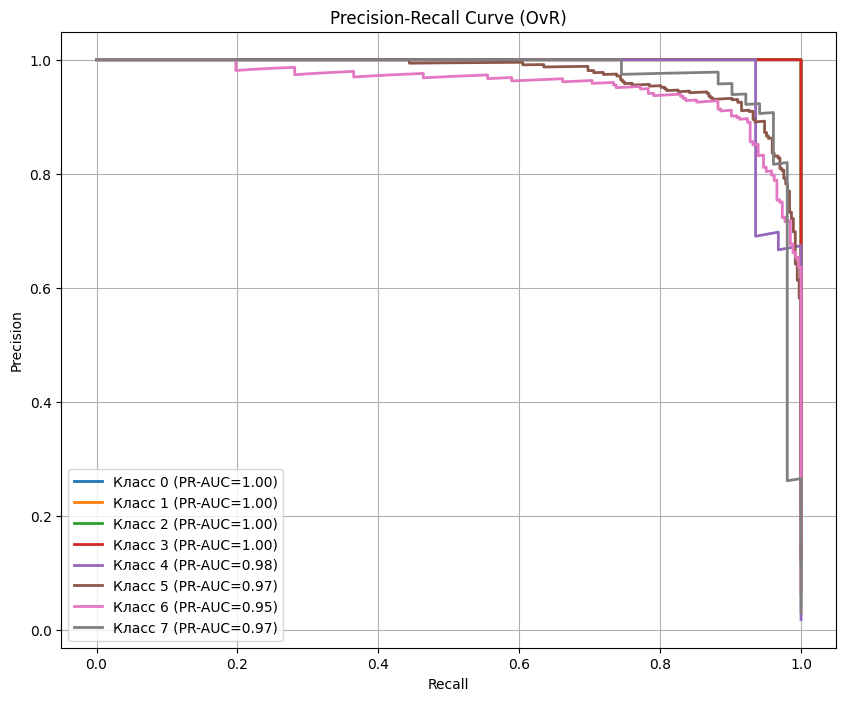

In [13]:
y_scores_np = test_preds.data if hasattr(test_preds, "data") else test_preds

# Преобразуем истинные метки в one-hot (для OvR)
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores_np[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'Класс {i} (PR-AUC={pr_auc:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (OvR)")
plt.legend()
plt.grid()
plt.show()
